In [6]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

df = pd.read_csv("alzheimers.csv")

## Data Preprocess

In [7]:
# data preprocess 
X = df.drop(columns=["PatientID", "DoctorInCharge", "Diagnosis"])
y = df['Diagnosis']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("scaler", StandardScaler(), numerical_cols)
])

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=100
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train size: {len(X_train)} | Val size: {len(X_val)} | Test size: {len(X_test)}")

Train size: 1289 | Val size: 430 | Test size: 430


### GridSearchCV to Select the Best Solver and Regularization Strength ($C$)
After tuning logistic regression with different solvers and C values, the best setup was **liblinear with C = 1**. It gave the highest cross-validated F1-score of 0.8788. In this task, misclassifying positive cases (patients with the disease) carries a higher cost. Therefore, F1-score would be a more appropriate metric for evaluation. Other solvers (like lbfgs and newton-cg) performed similarly, but liblinear consistently performed well across all C values and was slightly more stable, justifying its selection.  

When tuning logistic regression, we compared different solvers and regularization strengths.
Although multiple configurations gave similar F1-scores, liblinear stood out for its consistent performance across different C values.

As shown in the **heatmap**, its scores remained stable across the board, unlike other solvers which showed more variation.
We selected liblinear with C = 1 as the final setting because it performed well and consistently, which is important for reproducibility and reliability in medical models.  
  
While the baseline logistic regression model showed a noticeable gap in F1-scores between classes (0.86 vs. 0.73), we addressed this imbalance in the following part.

Best solver and C: {'logreg__C': 1, 'logreg__solver': 'liblinear'}
Best cross-validated F1-score: 0.7603
Final classification report on test set:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       278
           1       0.75      0.71      0.73       152

    accuracy                           0.81       430
   macro avg       0.80      0.79      0.79       430
weighted avg       0.81      0.81      0.81       430

Mean F1-score across folds:
param_logreg__solver   lbfgs  liblinear  newton-cg     sag    saga
param_logreg__C                                                   
0.1                   0.7554     0.7581     0.7554  0.7554  0.7554
0.5                   0.7574     0.7603     0.7574  0.7574  0.7574
1                     0.7588     0.7603     0.7588  0.7588  0.7588
2                     0.7593     0.7595     0.7593  0.7593  0.7593


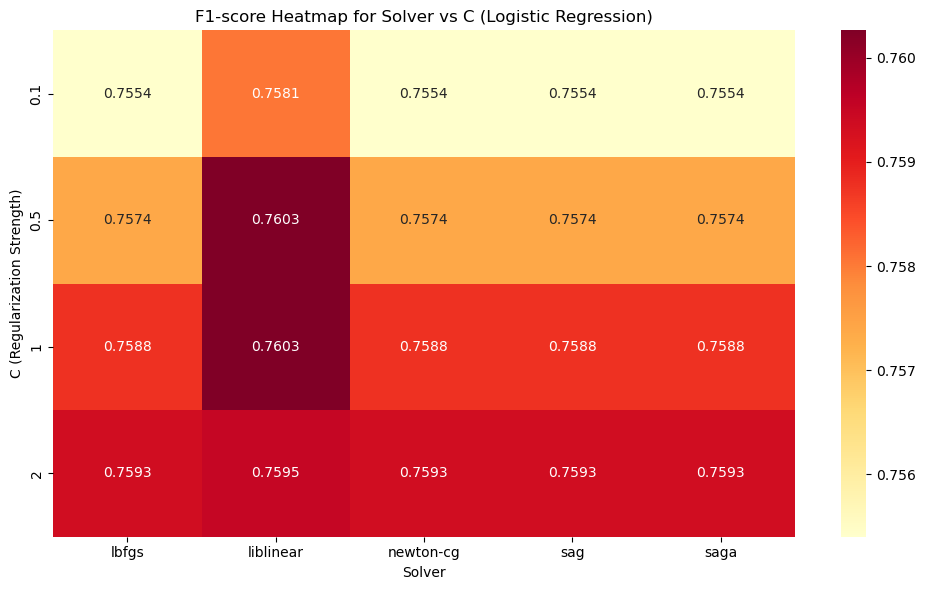

In [10]:
# Define parameter grid: test combinations of solvers and C values
param_grid = {
    'logreg__solver': ['liblinear', 'lbfgs', 'sag', 'saga', 'newton-cg'],
    'logreg__C': [0.1, 0.5, 1, 2]
}

# Build pipeline with preprocessing and logistic regression
model = Pipeline([
    ('preprocess', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Use repeated stratified 5-fold cross-validation (3 repeats) for stability
grid = GridSearchCV(
    model,
    param_grid,
    scoring='f1',  # Optimize for F1-score (Alzheimer's is minority class)
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100),
    n_jobs=-1
)

# Fit grid search on training data
grid.fit(X_train, y_train)

# Print best parameters and corresponding score
print("Best solver and C:", grid.best_params_)
print("Best cross-validated F1-score:", round(grid.best_score_, 4))

# Evaluate best model on test set
y_pred = grid.best_estimator_.predict(X_test)
print("Final classification report on test set:")
print(classification_report(y_test, y_pred))

# Create a pivot table for heatmap: mean F1-score across solver and C combinations
results = pd.DataFrame(grid.cv_results_)
pivot = results.pivot(index='param_logreg__C', columns='param_logreg__solver', values='mean_test_score')
pivot_sorted = pivot.sort_index().reindex(sorted(pivot.columns), axis=1)

print("Mean F1-score across folds:")
print(pivot.round(4))

# Visualize results as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_sorted, annot=True, fmt=".4f", cmap="YlOrRd")
plt.title("F1-score Heatmap for Solver vs C (Logistic Regression)")
plt.xlabel("Solver")
plt.ylabel("C (Regularization Strength)")
plt.tight_layout()
plt.show()

## Compare approaches to improve logistic regression
We compared four logistic regression configurations to evaluate the impact of different preprocessing and modeling strategies:  

The SelectKBest model (with top 2 features) achieved the best overall performance, with the highest F1-score (0.7706) and highest accuracy (84.43%). This suggests that reducing noise and focusing on the most relevant features improves both efficiency and predictive power.  
  
The baseline model (no extra scaling or selection) performed solidly, with an F1-score of 0.7618 and accuracy of 83.82%, confirming logistic regression's natural strength as a simple but relatively effective classifier.  

Applying a RobustScaler yielded almost identical results to baseline, indicating that outliers had minimal impact on model performance.  

Interestingly, adding class weight balancing slightly reduced performance (F1 = 0.76 → 0.7599, accuracy = 83.82% → 81.77%), suggesting the original data already had manageable class imbalance, and forced weighting may have overcorrected.  

In [11]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = {'accuracy': 'accuracy', 'f1': 'f1'}

def evaluate_model(name, pipeline):
    scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv)
    print(f"{name:<20} → Accuracy: {scores['test_accuracy'].mean():.4f} | F1-score: {scores['test_f1'].mean():.4f}")
    return {
        'model': name,
        'accuracy': scores['test_accuracy'].mean(),
        'f1': scores['test_f1'].mean()
    }

results = []

# Method 1: Baseline Logistic Regression with StandardScaler
pipe1 = Pipeline([
    ('preprocess', ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])),
    ('logreg', LogisticRegression(solver='liblinear'))
])
results.append(evaluate_model("Baseline", pipe1))

# Method 2: Logistic Regression with class_weight='balanced'
pipe2 = Pipeline([
    ('preprocess', ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])),
    ('logreg', LogisticRegression(solver='liblinear', class_weight='balanced'))
])
results.append(evaluate_model("Class Weight Balanced", pipe2))

# Method 3: Logistic Regression with RobustScaler
pipe3 = Pipeline([
    ('preprocess', ColumnTransformer([
        ('num', RobustScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])),
    ('logreg', LogisticRegression(solver='liblinear'))
])
results.append(evaluate_model("Robust Scaler", pipe3))

# Method 4: Logistic Regression with SelectKBest (numerical only)
pipe4 = Pipeline([
    ('preprocess', ColumnTransformer([
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('select', SelectKBest(score_func=f_classif, k=5))
        ]), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])),
    ('logreg', LogisticRegression(solver='liblinear'))
])
results.append(evaluate_model("SelectKBest Features", pipe4))

# Compare all methods
results_df = pd.DataFrame(results).sort_values(by='f1', ascending=False)
print("\nComparison Results (sorted by F1-score):")
print(results_df)

Baseline             → Accuracy: 0.8382 | F1-score: 0.7618
Class Weight Balanced → Accuracy: 0.8177 | F1-score: 0.7600
Robust Scaler        → Accuracy: 0.8379 | F1-score: 0.7610
SelectKBest Features → Accuracy: 0.8443 | F1-score: 0.7706

Comparison Results (sorted by F1-score):
                   model  accuracy        f1
3   SelectKBest Features  0.844265  0.770570
0               Baseline  0.838217  0.761786
2          Robust Scaler  0.837907  0.761032
1  Class Weight Balanced  0.817740  0.759967


## Final Modeling

In [12]:
# possible k candidates for SlectKBest approach
num_features = len(numerical_cols)

if num_features <= 7:
    k_values = list(range(1, num_features + 1))
else:
    k_values = list(range(3, min(num_features, 15) + 1, 2))

print("Candidate k values for feature selection:", k_values)

Candidate k values for feature selection: [3, 5, 7, 9, 11, 13, 15]


In [13]:
# find best k value 
best_k = None
best_f1 = 0

for k in k_values:
    pipe = Pipeline([
        ('preprocess', ColumnTransformer([
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('select', SelectKBest(score_func=f_classif, k=k))
            ]), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])),
        ('logreg', LogisticRegression(solver='liblinear', C=1, max_iter=1000))
    ])

    f1 = cross_val_score(pipe, X, y, scoring='f1', cv=5).mean()
    print(f"k = {k}: F1-score = {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Best k = {best_k} with F1-score = {best_f1:.4f}")

k = 3: F1-score = 0.6887
k = 5: F1-score = 0.7709
k = 7: F1-score = 0.7696
k = 9: F1-score = 0.7672
k = 11: F1-score = 0.7660
k = 13: F1-score = 0.7626
k = 15: F1-score = 0.7595
Best k = 5 with F1-score = 0.7709


In [14]:
# Final preprocessing using best k = 2
final_preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=5)) 
    ]), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Final logistic regression model with best solver and C
final_model = Pipeline([
    ('preprocess', final_preprocessor),
    ('logreg', LogisticRegression(solver='liblinear', C=1, max_iter=1000))
])

# Fit model
final_model.fit(X_train, y_train)

# Evaluate on validation set
val_acc = final_model.score(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")

# Evaluate on test set
y_pred = final_model.predict(X_test)
print("Final classification report on test set:")
print(classification_report(y_test, y_pred))


Validation Accuracy: 0.8419
Final classification report on test set:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       278
           1       0.79      0.74      0.76       152

    accuracy                           0.84       430
   macro avg       0.82      0.81      0.82       430
weighted avg       0.84      0.84      0.84       430



The final logistic regression model achieved an accuracy of 84% on the test set, with a validation accuracy of 84.19%, indicating consistent performance and no signs of overfitting.  

For class 1 (Alzheimer’s):  

- Recall = 0.74: The model correctly identified 74% of Alzheimer’s patients.

- Precision = 0.79: Among predicted Alzheimer’s cases, 79% were correct.

- F1-score = 0.76: A good balance between precision and recall.   

For class 0 (Non-Alzheimer’s):  

High precision and recall (0.86 and 0.89), with a strong F1-score of 0.88, confirming that the model rarely misclassifies healthy individuals.

Overall, the model is well-balanced, reliable, and particularly effective in reducing false positives, while maintaining a solid recall for Alzheimer’s cases — making it a strong and interpretable baseline.

# Visualiztion

### Confusion matrix

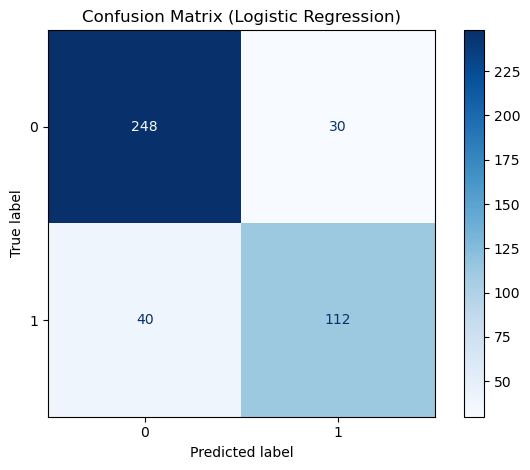

In [15]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.named_steps['logreg'].classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Logistic Regression)")
plt.tight_layout()
plt.show()

### AUC curve

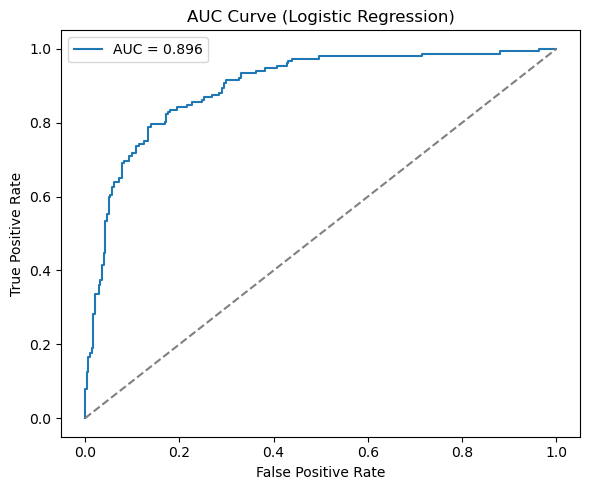

In [16]:
y_proba = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Curve (Logistic Regression)")
plt.legend()
plt.tight_layout()
plt.show()